## Hava Kalitesinin Sağlık Üzerine Etkisinin Tahmin Edilmesi

### Veri Yükleme ve İşleme

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

data = pd.read_csv('air_quality_health_impact_data.csv') # Veri yükleme
print(data.head()) 

# Kategorik verileri sayısal değerlere dönüştürme
label_encoders = {}
for column in data.select_dtypes(include="object").columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

if data.isnull().sum().sum() == 0:
    print("Eksik veri yok.")
else:
    print("Eksik veri var.")
    data.fillna(data.mean(), inplace=True) # Eksik verileri doldurma

# Hedef ve özellikler
X = data[[ 'AQI','PM10', 'PM2_5', 'NO2', 'SO2', 'O3', 'Temperature', 'Humidity', 'WindSpeed']] 
y = data['HealthImpactClass']
print(f"Özellik boyutları: {X.shape}, Hedef boyutları: {y.shape}")

   RecordID         AQI        PM10       PM2_5         NO2        SO2  \
0         1  187.270059  295.853039   13.038560    6.639263  66.161150   
1         2  475.357153  246.254703    9.984497   16.318326  90.499523   
2         3  365.996971   84.443191   23.111340   96.317811  17.875850   
3         4  299.329242   21.020609   14.273403   81.234403  48.323616   
4         5   78.009320   16.987667  152.111623  121.235461  90.866167   

           O3  Temperature   Humidity  WindSpeed  RespiratoryCases  \
0   54.624280     5.150335  84.424344   6.137755                 7   
1  169.621728     1.543378  46.851415   4.521422                10   
2    9.006794     1.169483  17.806977  11.157384                13   
3   93.161033    21.925276  99.473373  15.302500                 8   
4  241.795138     9.217517  24.906837  14.534733                 9   

   CardiovascularCases  HospitalAdmissions  HealthImpactScore  \
0                    5                   1          97.244041   
1   

### Veri Görselleştirme

HealthImpactClass
0.0    4808
1.0     579
2.0     273
3.0      95
4.0      56
Name: count, dtype: int64
               AQI         PM10        PM2_5          NO2          SO2  \
count  5811.000000  5811.000000  5811.000000  5811.000000  5811.000000   
mean    248.438476   148.654997   100.223714   102.293445    49.456838   
std     144.777638    85.698500    58.096612    57.713175    28.530329   
min       0.005817     0.015848     0.031549     0.009625     0.011023   
25%     122.951293    75.374954    49.435171    53.538538    24.887264   
50%     249.127841   147.634997   100.506337   102.987736    49.530165   
75%     373.630668   222.436759   151.340260   151.658516    73.346617   
max     499.858837   299.901962   199.984965   199.980195    99.969561   

                O3  Temperature     Humidity    WindSpeed  
count  5811.000000  5811.000000  5811.000000  5811.000000  
mean    149.312431    14.975500    54.776853     9.989177  
std      86.534240    14.483067    26.020786     

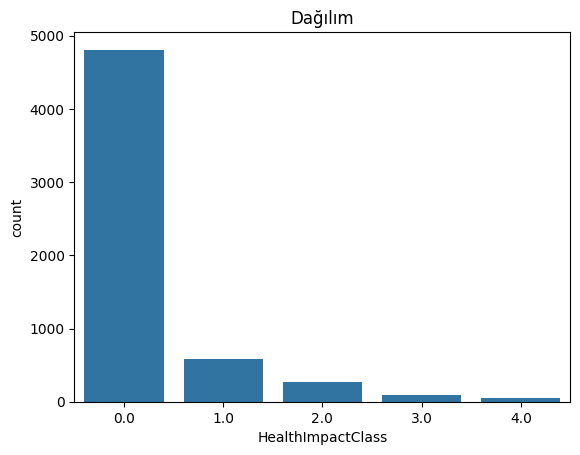

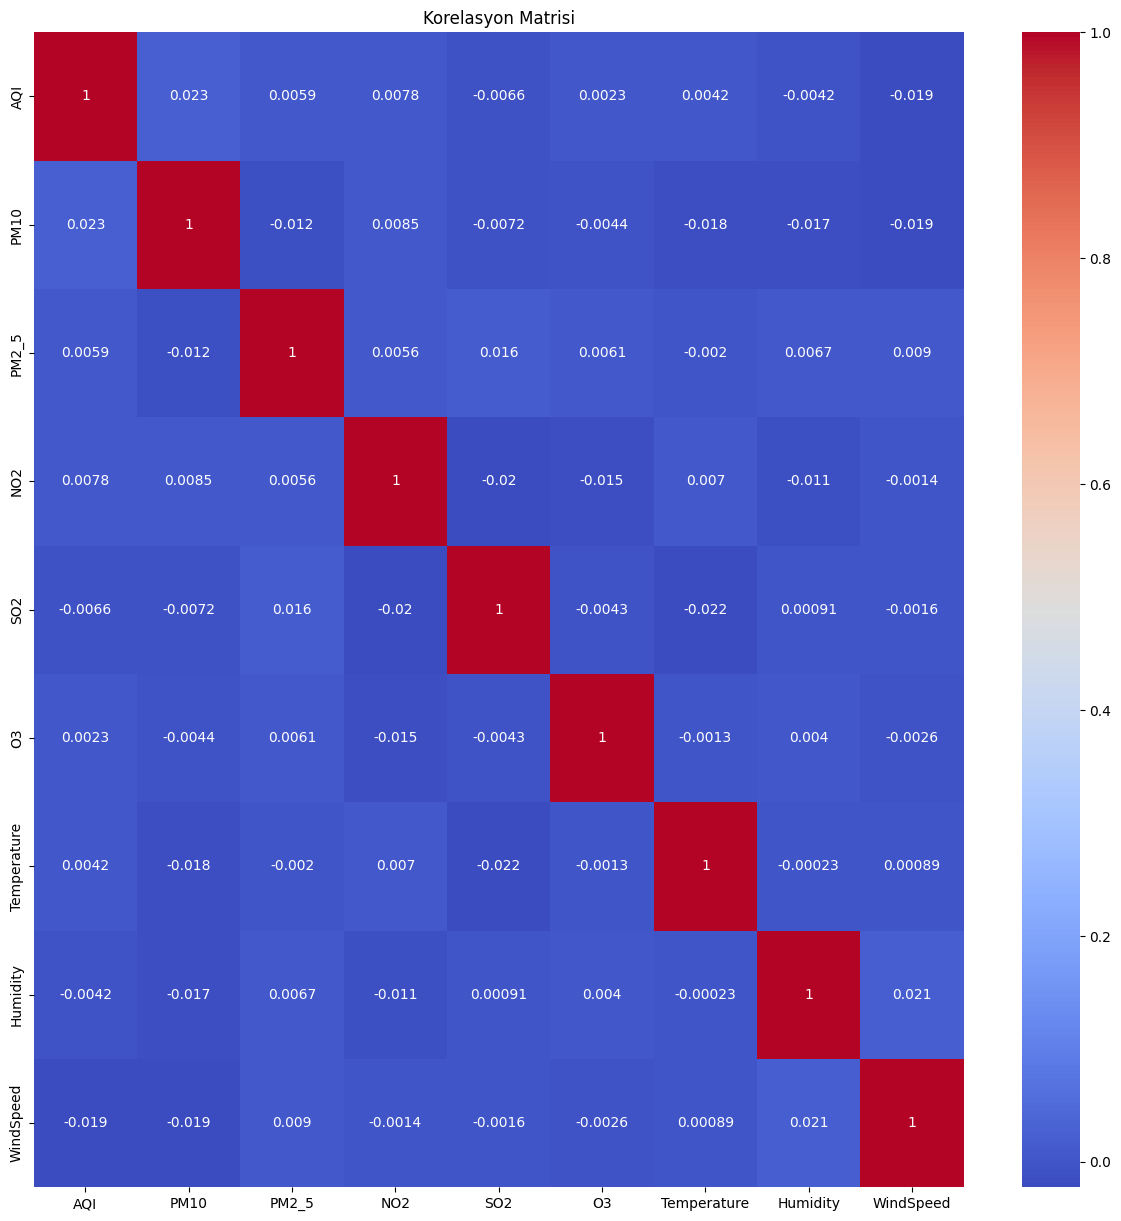

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

print(y.value_counts()) # Hedef sınıflarının dağılımı
print(X.describe()) # Özelliklerin istatistikleri

# Veri setindeki dağılımı gösteren grafik
sns.countplot(x=y)
plt.title("Dağılım")
plt.show()

correlation_matrix = X.corr()
plt.figure(figsize=(15,15))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Korelasyon Matrisi")
plt.show()

### Veri Dengesizliğinin Giderilmesi

In [3]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import numpy as np

# Özellikleri ölçeklendirme
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Veri dengesini kontrol etme
min_samples = np.min(np.bincount(y))
k_neighbors_value = max(1, min_samples - 1)

# SMOTE uygulama
smote = SMOTE(random_state=42, k_neighbors=k_neighbors_value)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

### Veri Seti Ayrımı

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled) # Veri setini eğitim ve test olarak ayırma

### Model Eğitimi - RandomForestClassifier()

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train) # Model eğitimi

y_pred_rf = model.predict(X_test) # Tahmin yapma

print("Accuracy:", accuracy_score(y_test, y_pred_rf)) # Doğruluk
print(classification_report(y_test, y_pred_rf)) # Sınıflandırma raporu

joblib.dump(model, 'modeller/model_randomForest.pkl')    # Modeli kaydetme

Accuracy: 0.8889351081530782
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85       962
         1.0       0.86      0.94      0.90       961
         2.0       0.94      0.88      0.91       962
         3.0       0.93      0.84      0.88       962
         4.0       0.87      0.94      0.91       961

    accuracy                           0.89      4808
   macro avg       0.89      0.89      0.89      4808
weighted avg       0.89      0.89      0.89      4808



['modeller/model_randomForest.pkl']

### Model Eğitimi - DecisionTreeClassifier()

In [6]:
from sklearn.tree import DecisionTreeClassifier

model_decisionTree = DecisionTreeClassifier(random_state=42)
model_decisionTree.fit(X_train, y_train) # Model eğitimi

y_pred_dt = model_decisionTree.predict(X_test) # Tahmin yapma

print("Accuracy:", accuracy_score(y_test, y_pred_dt)) # Doğruluk
print(f"decision tree: \n{classification_report(y_test, y_pred_dt)}") # Sınıflandırma raporu

joblib.dump(model_decisionTree, 'modeller/model_decisionTree.pkl')    # Modeli kaydetme

Accuracy: 0.7543677204658902
decision tree: 
              precision    recall  f1-score   support

         0.0       0.72      0.61      0.66       962
         1.0       0.77      0.79      0.78       961
         2.0       0.78      0.79      0.79       962
         3.0       0.72      0.77      0.74       962
         4.0       0.78      0.81      0.79       961

    accuracy                           0.75      4808
   macro avg       0.75      0.75      0.75      4808
weighted avg       0.75      0.75      0.75      4808



['modeller/model_decisionTree.pkl']

### Model Eğitimi - LogisticRegression()

In [7]:
from sklearn.linear_model import LogisticRegression

model_logistic = LogisticRegression(random_state=42)
model_logistic.fit(X_train, y_train) # Model eğitimi

y_pred_logistic = model_logistic.predict(X_test) # Tahmin yapma

print("Accuracy:", accuracy_score(y_test, y_pred_logistic)) # Doğruluk
print(f"logistic regression: \n{classification_report(y_test, y_pred_logistic)}") # Sınıflandırma raporu

joblib.dump(model_logistic, 'modeller/model_logistic.pkl')    # Modeli kaydetme

Accuracy: 0.4463394342762063
logistic regression: 
              precision    recall  f1-score   support

         0.0       0.42      0.42      0.42       962
         1.0       0.52      0.62      0.57       961
         2.0       0.49      0.61      0.54       962
         3.0       0.23      0.16      0.19       962
         4.0       0.49      0.42      0.45       961

    accuracy                           0.45      4808
   macro avg       0.43      0.45      0.43      4808
weighted avg       0.43      0.45      0.43      4808



['modeller/model_logistic.pkl']

### Model Eğitimi - K-Nearest Neighbors (KNN)

In [8]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train, y_train)

y_pred_knn = model.predict(X_test) # Tahmin yapma

print("Accuracy:", accuracy_score(y_test, y_pred_knn)) # Doğruluk
print(f"knn: \n{classification_report(y_test, y_pred_knn)}") # Sınıflandırma raporu

joblib.dump(model, 'modeller/model_knn.pkl')    # Modeli kaydetme

Accuracy: 0.8552412645590682
knn: 
              precision    recall  f1-score   support

         0.0       0.94      0.53      0.68       962
         1.0       0.85      0.94      0.89       961
         2.0       0.86      0.93      0.90       962
         3.0       0.85      0.92      0.88       962
         4.0       0.82      0.95      0.88       961

    accuracy                           0.86      4808
   macro avg       0.86      0.86      0.85      4808
weighted avg       0.86      0.86      0.85      4808



['modeller/model_knn.pkl']

### Model Eğitimi - Tensorflow / 50 Epoch - 32 Batch Size

In [9]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np


# Model oluşturma
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Modelin doğruluk skorları
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Modeli kaydetme
model.save('modeller/model_tensorflow_50e_32bs.keras')

Epoch 1/50


c:\Users\Aysenur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3668 - loss: 1.4183 - val_accuracy: 0.5927 - val_loss: 1.0846
Epoch 2/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.5818 - loss: 1.0813 - val_accuracy: 0.6566 - val_loss: 0.9168
Epoch 3/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.6505 - loss: 0.9325 - val_accuracy: 0.7250 - val_loss: 0.7937
Epoch 4/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6903 - loss: 0.8446 - val_accuracy: 0.7442 - val_loss: 0.7387
Epoch 5/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7096 - loss: 0.7948 - val_accuracy: 0.7499 - val_loss: 0.7054
Epoch 6/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7249 - loss: 0.7542 - val_accuracy: 0.7697 - val_loss: 0.6601
Epoch 7/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7272 - loss: 0.7286 - val_accuracy: 0.7759 - val_loss: 0.6408
Epoch 8/50
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1000us/step - accuracy: 0.7539 - loss: 0.6897 - val_accuracy: 0.7814

### Model Eğitimi - Tensorflow / 100 Epoch - 32 Batch Size

In [10]:
# Model oluşturma
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Modeli eğitme
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

# Modelin doğruluk skorları
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

model.save('modeller/model_tensorflow_100e_32bs.keras')

Epoch 1/100


c:\Users\Aysenur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3839 - loss: 1.4096 - val_accuracy: 0.5568 - val_loss: 1.1103
Epoch 2/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.5577 - loss: 1.1071 - val_accuracy: 0.6720 - val_loss: 0.9230
Epoch 3/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 0.9589 - val_accuracy: 0.7185 - val_loss: 0.8239
Epoch 4/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6827 - loss: 0.8580 - val_accuracy: 0.7364 - val_loss: 0.7431
Epoch 5/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.7097 - loss: 0.7959 - val_accuracy: 0.7390 - val_loss: 0.7191
Epoch 6/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.7289 - loss: 0.7456 - val_accuracy: 0.7741 - val_loss: 0.6626
Epoch 7/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7421 - loss: 0.7036 - val_accuracy: 0.7816 - val_loss: 0.6397
Epoch 8/100
481/481 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7501 - loss: 0.6862 - val_accura

### Model Eğitimi - Tensorflow / 50 Epoch - 64 Batch Size

In [11]:
# Model oluşturma
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Modeli eğitme
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

# Modelin doğruluk skorları
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

model.save('modeller/model_tensorflow_50e_64bs.keras')

Epoch 1/50


c:\Users\Aysenur\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


241/241 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3614 - loss: 1.4468 - val_accuracy: 0.5222 - val_loss: 1.1737
Epoch 2/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5277 - loss: 1.1569 - val_accuracy: 0.6605 - val_loss: 0.9681
Epoch 3/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6233 - loss: 0.9930 - val_accuracy: 0.6985 - val_loss: 0.8514
Epoch 4/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.9106 - val_accuracy: 0.7172 - val_loss: 0.7843
Epoch 5/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6917 - loss: 0.8501 - val_accuracy: 0.7419 - val_loss: 0.7522
Epoch 6/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7024 - loss: 0.8099 - val_accuracy: 0.7585 - val_loss: 0.7066
Epoch 7/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7289 - loss: 0.7513 - val_accuracy: 0.7671 - val_loss: 0.6880
Epoch 8/50
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7218 - loss: 0.7462 - val_accuracy: 0.7645 - val_